# Initial Analyses
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Read in some real data
2. Perform some simple data clean-up
3. Some visualizations with Pandas
4. Simple statistics with SciPy and StatsModels



# Updating SMILE

- First you can test whether there is a new version Kivy, which is the primary dependency of SMILE:

```bash
conda install -c conda-forge kivy==1.11.1
```

- Then you can update SMILE right from the GitHub repository (note the upgrade option at the end):

```bash
pip install git+https://github.com/compmem/smile --upgrade
```

# Deep Dive Into Single Subj

- Let's explore one subject's data and learn stuff along the way!
- Where are the data?

In [1]:
ls data/Taskapalooza/

s001/  s002/  s003/


In [71]:
from smile.log import log2dl
import pandas as pd

# note use of kwargs to add subject info to the dataframe
df_i = pd.DataFrame(log2dl('data/Taskapalooza/s003/20201027_110222/log_image_test_0.slog', subj='s003'))
df_w = pd.DataFrame(log2dl('data/Taskapalooza/s003/20201027_110222/log_word_test_0.slog', subj='s003'))
df_f = pd.DataFrame(log2dl('data/Taskapalooza/s003/20201027_110222/log_flanker_0.slog', subj='s003'))
df_m = pd.DataFrame(log2dl('data/Taskapalooza/s003/20201027_110222/log_math_distract', subj='s003'))

df_m.head(10)


,correct,resp,rt,trial_appear_time,trial_appear_error,press_time_time,press_time_error,log_time,text,condition,correct_key,subj,log_num
0,True,J,4.184639,2037.652723,0.0,2041.837362,0.000466,2042.337362,9-5-10=-6,True,J,s003,0
1,True,F,1.514299,2043.341123,0.0,2044.855422,0.000426,2045.355422,6+5+4=14,False,F,s003,0
2,True,F,1.808643,2046.363993,0.0,2048.172636,0.000537,2048.672636,5-3-1=0,False,F,s003,0
3,True,J,2.157810,2049.683841,0.0,2051.841651,0.000438,2052.341651,7+8+9=24,True,J,s003,0
4,True,J,0.923231,2053.354454,0.0,2054.277685,0.000521,2054.777685,10+1+3=14,True,J,s003,0
5,True,F,1.482598,2188.483444,0.0,2189.966042,0.000558,2190.466042,8+10+2=19,False,F,s003,0
6,True,F,1.129487,2191.476571,0.0,2192.606058,0.000468,2193.106058,10+1+8=29,False,F,s003,0
7,True,J,3.411656,2194.113561,0.0,2197.525217,0.000485,2198.025217,3-9-2=-8,True,J,s003,0
8,True,F,2.538657,2199.034644,0.0,2201.573302,0.000469,2202.073302,6-7-1=8,False,F,s003,0
9,True,J,1.469808,2203.087678,0.0,2204.557487,0.000467,2205.057487,10+6+7=23,True,J,s003,0


## Some data clean-up

In [72]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    ublocks = df.block_num.unique()
    for b in ublocks:
        dfb = df.loc[df.block_num==b]
        uval = dfb[type_col].unique()
        if len(uval) > 1:
            # it's mixed
            df.loc[df.block_num==b, 'cond'] = 'mixed'
        else:
            # it's the pure
            df.loc[df.block_num==b, 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

## Statistics in Python

- Once your data are in a nice tabular form, you are all set to start asking questions
- In this section we'll introduce:
  - Grouping and visualization with Pandas
  - Statistics with SciPy
  - Simple Statistics with StatsModels

## Stats in SciPy

- Many useful statistics are available from [SciPy](https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)

In [83]:
import numpy as np
from scipy import stats

## Checking for math performance

- One test to make sure participants are trying during the task is to check performance on the math task
- ***Question: Did they perform above chance on the math problems?***

In [86]:
# we can calculate mean performance, but is it significant?
df_m['correct'].mean()

0.9775280898876404

## The binomial test

- We need to take into account the number of problems
- and whether they did significantly above what could be expected by chance
- The binomal tests this for specific probabilities with *two* outcomes
  - Like flipping a coin and determining whether it is fair or biased

In [133]:
# generate some random data
dat = np.random.choice([0, 1], size=20, p=[0.3, 0.7])
print(dat)

# calculate whether it deviates from chance
stats.binom_test(dat.sum(), len(dat), p=0.5)

[0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1]


0.04138946533203125

In [93]:
# determine number correct and total number of problems
num_correct = df_m['correct'].sum()
num_tries = len(df_m)

# perform the statistic
p_val = stats.binom_test(num_correct, n=num_tries, 
                         p=0.5, alternative='greater')
prop_correct = num_correct/num_tries

# report the results (with some string formatting)
print('Prop correct: {:0.2f} (p={:0.4f})'.format(prop_correct, p_val))

Prop correct: 0.98 (p=0.0000)


## What about performance on the easy conditions?

- Another way to test for task compliance is to check the performance on the easiest task conditions.
- ***Question: Did the participant perform above chance on the congruent flanker trials?***

In [97]:
# grab a boolean index for the congruent trials
ind = df_f['condition']=='congruent'
num_correct = df_f[ind]['correct'].sum()
num_tries = ind.sum()

# perform the statistic
p_val = stats.binom_test(num_correct, n=num_tries, 
                         p=0.5, alternative='greater')
prop_correct = num_correct/num_tries

# report the results (with some string formatting)
print('Prop correct: {:0.2f} (p={:0.4f})'.format(prop_correct, p_val))

Prop correct: 1.00 (p=0.0000)


## Deeper Dive into Flanker

- The typical congruency effect is that participants show lower accuracy and slower reaction times in the incongruent relative to the congruent conditions
- Let's check that for our participant!

In [134]:
# look at mean performance by condition
df_f.groupby(['condition'])['correct'].mean()

condition
congruent      1.000000
incongruent    0.989583
neutral        1.000000
Name: correct, dtype: float64

In [135]:
# how about RT by condition?
df_f.groupby(['condition'])['rt'].mean()

condition
congruent      0.682562
incongruent    0.893463
neutral        0.592118
Name: rt, dtype: float64

## *t*-test to compare distributions

- The *t*-test assesses whether two normal distributions are the same (or whether one distribution is different from a fixed value)
- Assumes your data are independent and normally distributed
- There are both paired (1-sample) and non-paired (independent) versions of the t-test available in scipy

<AxesSubplot:>

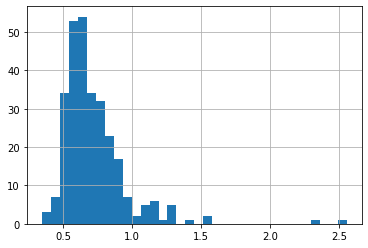

In [136]:
# how do our RTs look?
df_f['rt'].hist(bins='auto')

<AxesSubplot:>

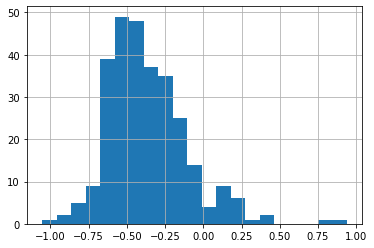

In [138]:
# how about if we take the log?
np.log(df_f['rt']).hist(bins='auto')

In [139]:
# let's just add in that column
df_f['log_rt'] = np.log(df_f['rt'])

## Boxplots get you closer to your data

- While it's hard to look at individual data points, it can still be very useful to visualize your data
- A box plot is a non-parametric visualization of your data with the:
  - Minimum (excluding outliers) as the upper whisker
  - Maximum (excluding outliers) as the lower whisker
  - Median (50% quantile) line inside the box
  - 25% and 75% quantile of your data as the upper and lower box sides
  - Outliers as dots

<AxesSubplot:title={'center':'log_rt'}, xlabel='[condition]'>

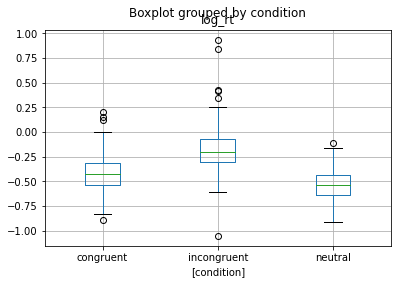

In [169]:
# visualization of the comparison
df_f.boxplot(column=['log_rt'], by=['condition'])

In [146]:
# we can check for statistical signficance of RTs
# with an unpaired independed samples t-test
stats.ttest_ind(df_f[df_f['condition']=='congruent']['log_rt'],
                df_f[df_f['condition']=='incongruent']['log_rt'])


Ttest_indResult(statistic=-7.040795742871274, pvalue=3.3949886939953275e-11)

In [170]:
# are the neutral even better than congruent?
stats.ttest_ind(df_f[df_f['condition']=='congruent']['log_rt'],
                df_f[df_f['condition']=='neutral']['log_rt'])


Ttest_indResult(statistic=5.321568309157725, pvalue=2.879595834046887e-07)

## Non-parametric statistics

- There is an entire sub-field of statistics dedicated to situations where you can not assume your data come from normal distributions.
- Here, the approach is to turn the values into ranks and test whether then mean *ranks* are different.
- There are both paired (signed-rank test) and un-paired versions (Mann-Whitney U test) available in scipy.

In [174]:
# perform the non-paired non-parametric test on RTs
stats.mannwhitneyu(df_f[df_f['condition']=='congruent']['rt'],
                   df_f[df_f['condition']=='incongruent']['rt'])

MannwhitneyuResult(statistic=1854.0, pvalue=4.2769954727175223e-13)

## Regression and beyond!

- More complicated questions require more complicated models
- The most standard approach in statistics is regression:

![](https://scipy-lectures.org/_images/math/8c27948834377cd91a6907f91d1f87acb32f1817.png)

- Here `y` is the dependent variable and `x` is the independent variable.
- This is also often called *endogenous* and *exogenous*.

## Statsmodels allows us to specify regressions as formulas

- There are many ways to fit regression models that often depend on your dependent data
  - e.g., ordinary least squares vs. logistic regression

In [179]:
import statsmodels.formula.api as smf

***Question: Are there differences in accuracy between conditions?***

In [190]:
# dependent variables can't be boolean
df_f['correct_int'] = df['correct'].astype(int)

# build a logistic regression
model = smf.logit("correct_int ~ condition", df_f).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.368516
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            correct_int   No. Observations:                  288
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                            2
Date:                Thu, 29 Oct 2020   Pseudo R-squ.:                0.003898
Time:                        13:28:08   Log-Likelihood:                -106.13
converged:                       True   LL-Null:                       -106.55
Covariance Type:            nonrobust   LLR p-value:                    0.6601
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.1518      0.334      6.440      0.000       1.497       2.807
condition[T.incongruent]    -0.3841      0.442     -0.869      0.385      -1.250       0.482
condition[T.neutral]        -0.1070      0.463     -0.231      0.817      -1.014       0.800
============================================================================================
"""

***Question: Can we test for differences in RTs between conditions with regression?***

In [191]:
# build a linear regression
model = smf.ols("log_rt ~ condition", df_f).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     76.78
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           2.12e-27
Time:                        13:30:39   Log-Likelihood:                 35.506
No. Observations:                 288   AIC:                            -65.01
Df Residuals:                     285   BIC:                            -54.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.4018      0.022    -18.309      0.000      -0.445      -0.359
condition[T.incongruent]     0.2458      0.031      7.921      0.000       0.185       0.307
condition[T.neutral]        -0.1332      0.031     -4.293      0.000      -0.194      -0.072
==============================================================================
Omnibus:                       68.720   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.077
Skew:                           0.946   Prob(JB):                     3.72e-59
Kurtosis:                       7.341   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Assignment before next class

- We will post a small set of analyses to run on some of the other data based on the examples in this class
- This will be due on ***Thursday*** next week

### See you next week!!!